In [1]:
import pandas as pd
from datetime import datetime

import statsmodels.api as sm
import config as c

import seaborn as sns
import numpy as np

# sns.set(
#     context="paper",
#     style="white",
#     palette="deep",
#     font="sans-serif",
#     font_scale=1.2,
#     color_codes=True,
#     rc=None,
# )

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import warnings

warnings.filterwarnings("ignore")

In [2]:
# Dataframe Pre-Processing
def data_pre_processing(df):
    # Reading the data
    df["Datetime"] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df["Datetime"]]

    # Making sure there are no duplicated data
    # If there are some duplicates we average the data during those duplicated days
    df = df.groupby("Datetime", as_index=False)["kwh"].mean()

    # Sorting the values
    df.sort_values("Datetime", inplace=True)

    # Setting index date
    df.set_index(df["Datetime"], inplace=True)

    # Dropping column Datetime
    df.drop("Datetime", axis=1, inplace=True)
    
    # Remove missing values.
    df.dropna()

    return df


def data_outlier_removal(df, hourly=True, daily=True):
    if hourly:
        # Remove outlier data
        df.drop(df[df.kwh < 0.001].index, inplace=True)
        df.drop(df[df.kwh > 1.0].index, inplace=True)

    if daily:
        # Removing data values from dataframe
        df.drop(df[df.kwh < 2].index, inplace=True)
        df.drop(df[df.kwh > 7].index, inplace=True)

    return df


# TREND PLOT
def tsa_plot(df, model_type, periods, save_fig, fig_name):
    decomposition = sm.tsa.seasonal_decompose(df, model=model_type, period=periods)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(7, 6))
    decomposition.observed.plot(ax=ax1, title="Observed")
    decomposition.trend.plot(ax=ax2, title="Trend")
    decomposition.seasonal.plot(ax=ax3, title="Seasonality")
    decomposition.resid.plot(ax=ax4, title="Residual", style=["o"])

    # Remove labels from first 3 graphs
    ax1.get_xaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    ax3.get_xaxis().set_visible(False)

    # Define the date format
    date_form = DateFormatter("%m-%d")
    ax4.xaxis.set_major_formatter(date_form)
    # Ensure a major tick for each week using (interval=1)
    ax4.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    ax4.set(xlabel="Date")
    plt.xticks(rotation=0)

    fig.tight_layout()

    if save_fig:
        plt.show()
        fig.savefig(f"{c.loc_fig}/{fig_name}")


# SCATTER PLOT
def data_visualization(df="df", sca_tter=False, title_name="10 secs"):
    # Plot of data with specified details, data x-axis tick labels reformatted in desired way
    fig, ax = plt.subplots()

    # Add x-axis and y-axis
    if sca_tter:
        ax.scatter(df.index.values, df["kwh"], color="Slateblue", alpha=0.6)
    else:
        ax.plot(df.index.values, df["kwh"], color="Slateblue", alpha=0.6)

    # Set title and labels for axes
    ax.set(
        xlabel="Date",
        ylabel="Energy (kWh)",
        title=f"Energy consumption per {title_name}",
    )
    # xlim=["2020-01-20", "2020-04-01"])

    # Define the date format
    date_form = DateFormatter("%d/%m")
    ax.xaxis.set_major_formatter(date_form)
    # Ensure a major tick for each week using (interval=1)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

    plt.xticks(rotation=30)

    sns.despine()
    fig.show()
    fig.savefig(f"{c.loc_fig}/plot {title_name}")


# Resampling data frame by days of week average
def data_vis_weekdays(df, title_name="Daywise average"):
    # Plotting data by the dayes of week
    fig, ax = plt.subplots()

    # Add x-axis and y-axis
    ax.plot(df.index.values, df["kwh"], marker="o", color="Slateblue", alpha=0.6)

    # Set title and labels for axes
    ax.set(
        xlabel="Date", ylabel="Energy (kWh)", title="Energy consumption daywise average"
    )

    plt.xticks(rotation=30)

    sns.despine()
    plt.show()
    fig.savefig(f"{c.loc_fig}/plot {title_name}")


# Plot donught pie chart
def data_vis_donught(df, title_name="Daywise average percentage"):
    # Plot donught pie chart
    labels = df.index
    sizes = df["kwh"]

    # colors
    # colors = ['#c88691','#ad85ba','#95a1c3', '#74a18e','#b2c891','#949494','#d6d6d6']
    colors = [
        "#687995",
        "#b78f78",
        "#6c9174",
        "#a46e70",
        "#8b84a1",
        "#85796e",
        "#c4a1ba",
    ]

    # explsion
    explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)

    plt.pie(
        sizes,
        colors=colors,
        labels=labels,
        autopct="%1.1f%%",
        startangle=90,
        pctdistance=0.85,
        explode=explode,
    )

    # draw circle
    centre_circle = plt.Circle((0, 0), 0.70, fc="white")
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title("Energy consumption daytype average composition")
    # ax1.axis("equal")
    plt.tight_layout()
    plt.savefig(f"{c.loc_fig}/plot {title_name}")
    plt.show()


# Grouping whole data on hourly basis
def data_vis_area_hourly(df, title_name="Daytime average"):
    hourly = df.groupby(df.index.time).mean()

    # Creating x ticks
    hourly_x_ticks = 4 * 60 * 60 * np.arange(6)

    # Plotting data by the hours
    hourly.plot(
        kind="area", xticks=hourly_x_ticks, color="Slateblue", alpha=0.2, legend=False
    )
    plt.xlabel("Day time")
    plt.ylabel("Energy (kWh)")
    plt.title("Energy consumption daily daytime average")

    sns.despine()
    plt.savefig(f"{c.loc_fig}/plot {title_name}")
    plt.show()


# Grouping whole data on weekday and weekend basis, plotting in same graph
def data_vis_weekend_weekday(df, title_name="Daytype average"):
    weekend = np.where(df.index.weekday < 5, "Weekday", "Weekend")
    days_hour = df.groupby([weekend, df.index.time]).mean()

    # Creating x ticks
    hourly_x_ticks = 4 * 60 * 60 * np.arange(6)

    # Plotting data by the hours for weekdays and weekends in same graph
    # gca stands for 'get current axis'
    ax = plt.gca()

    days_hour.loc["Weekday"].plot(
        ax=ax, xticks=hourly_x_ticks, ylim=(0, 0.5), color="skyblue"
    )
    days_hour.loc["Weekend"].plot(
        ax=ax, xticks=hourly_x_ticks, ylim=(0, 0.5), color="navy"
    )

    # Modify legend
    ax.legend(["Weekdays", "Weekend"], frameon=False)

    plt.xlabel("Day time")
    plt.ylabel("Energy (kWh)")
    plt.title("Energy consumption daytype average")

    sns.despine()
    plt.savefig(f"{c.loc_fig}/plot {title_name}")
    plt.show()


In [3]:
# LOAD DATASET
powerdata = pd.read_csv(f"{c.loc_dat}/Datetime_kwh_hr_2001_3103_org.csv")

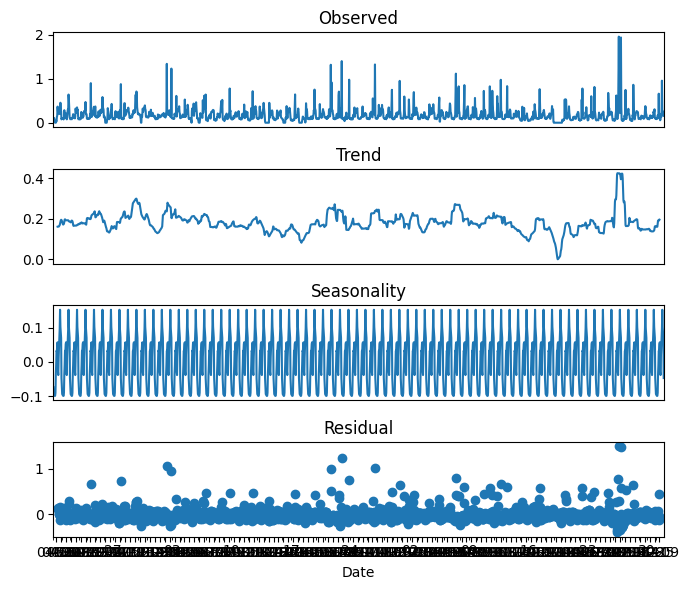

In [4]:
# Hourly dataframe trend plot
df1 = data_pre_processing(powerdata)
tsa_plot(df1, model_type='additive', periods=24, save_fig=True, fig_name='TSDecomposeHourly')

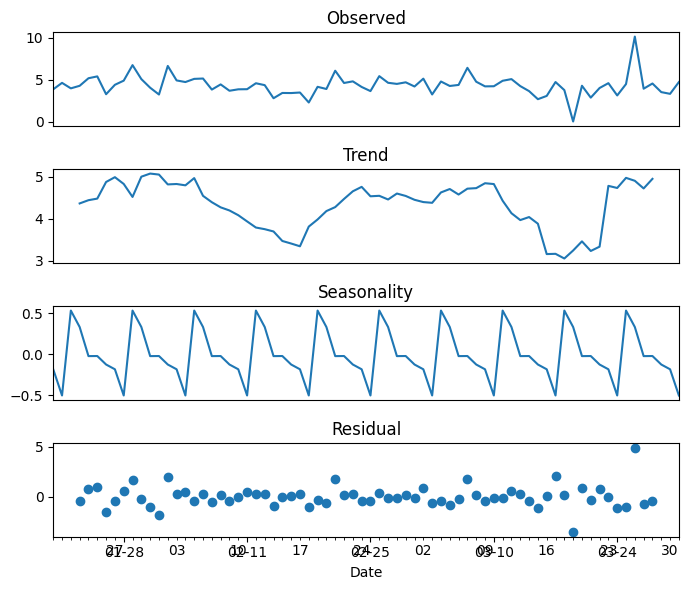

In [5]:
# Daily Dataframe Trend Plot
df2 = df1.resample('D').sum()
tsa_plot(df2, model_type='additive', periods=7, save_fig=True, fig_name='TSDecomposeDaily')

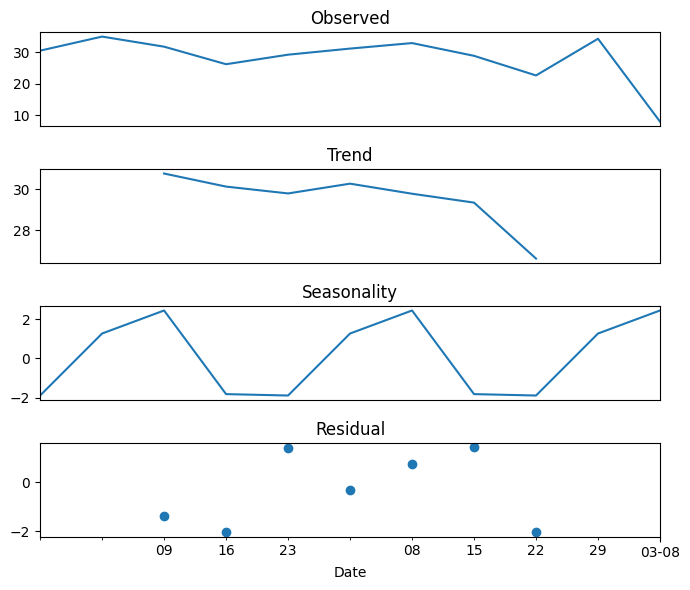

In [6]:
# Weekly Dataframe Trend Plot
df3 = df1.resample('W').sum()
tsa_plot(df3, model_type='additive', periods=4, save_fig=True, fig_name='TSDecomposeWeekly')

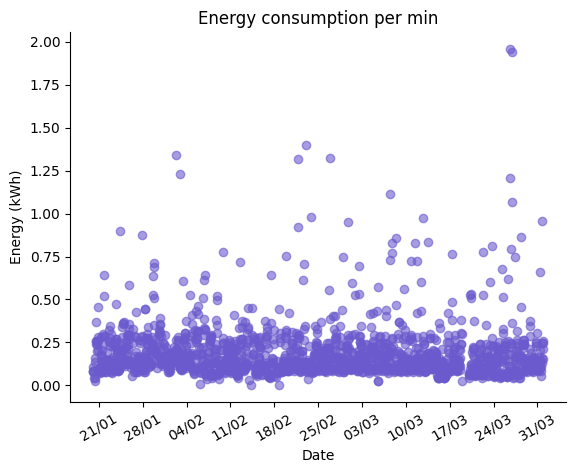

In [7]:
# Initial data visualization
df1 = pd.read_csv(f"{c.loc_dat}/Datetime_kwh_hr_2001_3103_org.csv", index_col='Datetime', parse_dates=True, na_values=['0'])
# Resampling data frame for per min data frequency
dfMin = df1.resample('Min').sum()
# Removing data values from dataframe
dfMin.drop(dfMin[dfMin.kwh < 0.001].index, inplace=True)
data_visualization(df=dfMin, sca_tter=True, title_name="min")

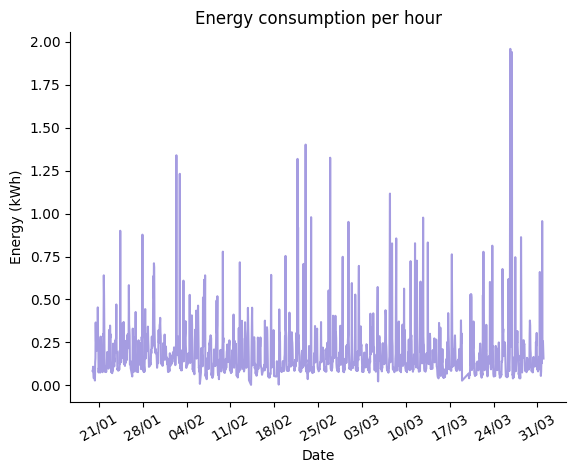

In [8]:
# Resampling data frame for per hour data frequency
dfHour = df1.resample('H').sum()
# Removing data values from dataframe
dfHour.drop(dfHour[dfHour.kwh < 0.001].index, inplace=True)
data_visualization(df=dfHour, sca_tter=False, title_name="hour")

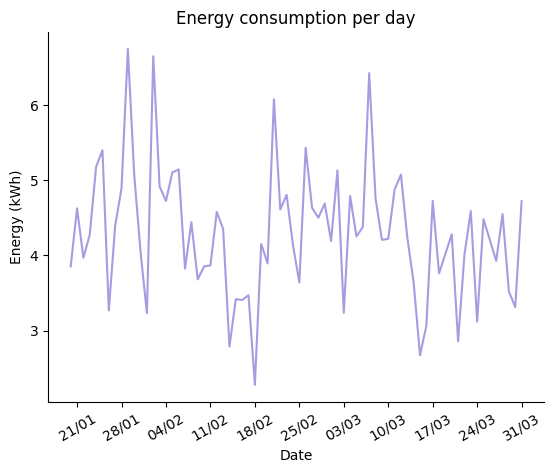

In [9]:
# Resampling data frame for per day data frequency
dfDay = df1.resample('D').sum()
# Removing data values from dataframe
dfDay.drop(dfDay[dfDay.kwh < 2].index, inplace=True)
dfDay.drop(dfDay[dfDay.kwh > 7].index, inplace=True)
data_visualization(df=dfDay, sca_tter=False, title_name="day")

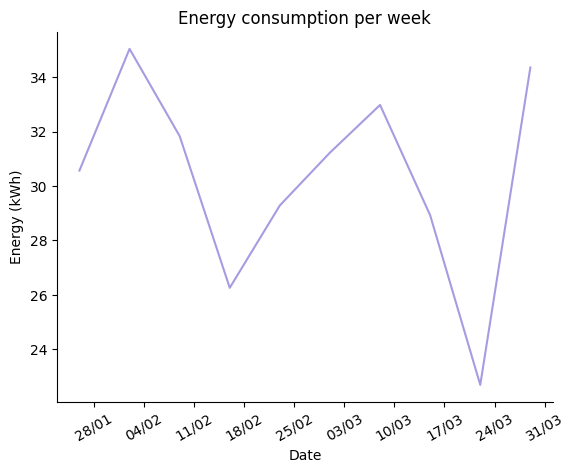

In [10]:
# Resampling data frame for per week data frequency
dfWeek = df1.resample('W').sum()
dfWeek = dfWeek.truncate(before='2020-01-20', after='2020-03-31')
data_visualization(df=dfWeek, sca_tter=False, title_name="week")

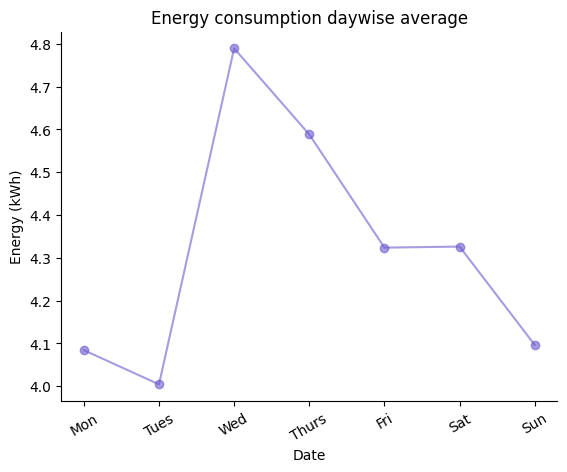

In [11]:
# Resampling data frame by days of week
dfWeekDays = dfDay.groupby(dfDay.index.dayofweek).mean()
dfWeekDays.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
data_vis_weekdays(dfWeekDays, title_name="Daywise average")

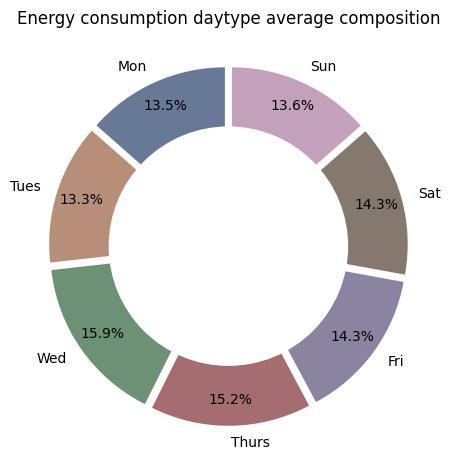

In [12]:
data_vis_donught(dfWeekDays, title_name="Daywise average percentage")

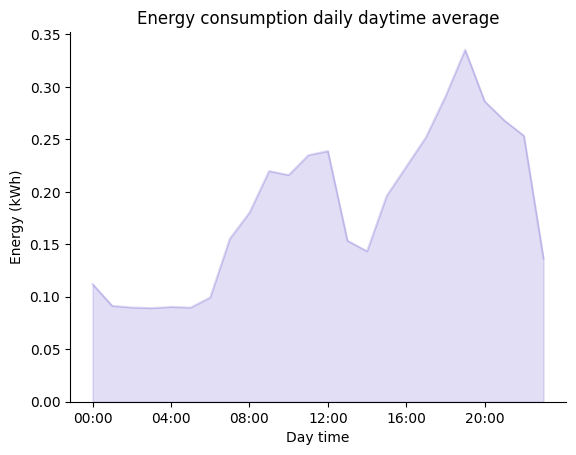

In [13]:
# Grouping whole data on hourly basis 
data_vis_area_hourly(dfMin, title_name="Daytime average")

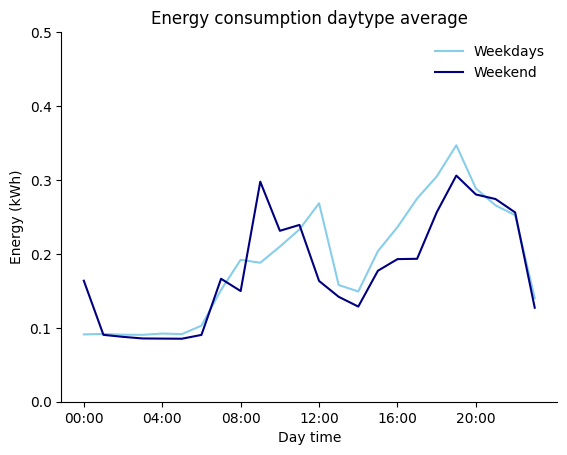

In [14]:
# Grouping whole data on weekday and weekend basis, plotting in same graph 
data_vis_weekend_weekday(dfHour, title_name="Daytype average")